In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, classification_report



2024-04-25 11:13:04.111306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import tensorflow as tf
from keras import __version__ as keras_version

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras_version)

TensorFlow version: 2.16.1
Keras version: 3.2.0


In [ ]:
''' 
FICHEROS:
- data_ficheros: Contiene archivos CSV que probablemente incluyen listas de imágenes y sus etiquetas correspondientes. 
Estos archivos son importantes para saber qué imágenes debO usar para entrenar y probar mi modelo, y cuáles son sus etiquetas ("happy" o "sadness").

- sample_submission.csv es un archivo de ejemplo que muestra cómo debo formatear mis predicciones para enviarlas a la competencia.

- test_set.csv contiene los nombres de los archivos de imagen que debo clasificar para la competencia.

- train_set.csv incluye los nombres y etiquetas de las imágenes que usaré para entrenar el modelo.

- data_images: Directorio que contiene imágenes reales organizadas en subdirectorios.

Dentro de train, tengo subdirectorios para cada clase de imagen ("happy" y "sadness"), que se utilizan junto con ImageDataGenerator para cargar y etiquetar automáticamente las imágenes durante el entrenamiento y la validación.
El directorio test contiene imágenes que debos clasificar y luego enviar tus predicciones a Kaggle.

En resumen, Por un lado, los ficheros (archivos CSV) sirven como un índice o referencia a las imágenes y sus etiquetas, y por otro lado, los directorios con imágenes que son los datos reales que alimentarán al modelo.
'''

In [2]:
# Configuración para reproducibilidad
np.random.seed(42)

# Cargar el conjunto de datos de entrenamiento
train_df = pd.read_csv("data_ficheros/train_set.csv")


In [3]:
# Mostrar las primeras filas del DataFrame para revisar
train_df.head()

,Unnamed: 0,id_img,paths,label
0,0,100,data\train\happy\100.jpg,happy
1,1,10000,data\train\happy\10000.jpg,happy
2,2,10001,data\train\happy\10001.jpg,happy
3,3,10005,data\train\happy\10005.jpg,happy
4,4,10035,data\train\happy\10035.jpg,happy


In [4]:
# Verificar el balance de las clases si es necesario
train_df['label'].value_counts()

label
happy      7164
sadness    4938
Name: count, dtype: int64

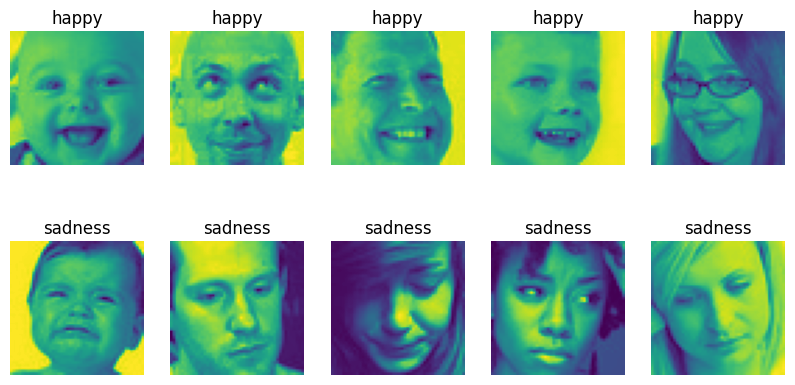

In [3]:
# COMPROBACIÓN DE QUELAS IMÁGENES ESTÁN AÑADIDAS A LA CARPERTA CORRESPONDIENTE

# Definir las rutas de las carpetas
happy_dir = 'data_images/train/2_happy'
sadness_dir = 'data_images/train/1_sadness'

# Obtener una lista de nombres de archivos de cada clase
happy_files = os.listdir(happy_dir)[:5]  # Cambiar el 5 por más si quieres ver más imágenes
sadness_files = os.listdir(sadness_dir)[:5]

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 5))

# Visualizar las imágenes de la clase 'happy'
for i, file in enumerate(happy_files):
    img = plt.imread(os.path.join(happy_dir, file))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('happy')
    plt.axis('off')

# Visualizar las imágenes de la clase 'sadness'
for i, file in enumerate(sadness_files):
    img = plt.imread(os.path.join(sadness_dir, file))
    plt.subplot(2, 5, i+6)  # Asegúrate de que el índice no se solape con las imágenes anteriores
    plt.imshow(img)
    plt.title('sadness')
    plt.axis('off')

plt.show()


In [5]:


# Definir el generador de imágenes con un split de validación del 20%
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Suponiendo que quieres el 20% de las imágenes para validación
)

# Generador de entrenamiento con los datos de entrenamiento
train_generator = datagen.flow_from_directory(
    'data_images/train',  # Este es el directorio que contiene las subcarpetas 'happy' y 'sadness'
    target_size=(150, 150),  # O cualquier tamaño al que quieras redimensionar las imágenes
    batch_size=32,
    class_mode='binary',  # O 'categorical' si es multiclase
    subset='training',  # Especifica que este es el conjunto de entrenamiento
    shuffle=True,  # Asegúrate de que los datos se barajen en cada época
    seed=42  # Semilla para reproducibilidad
)

# Generador de validación con los mismos datos
validation_generator = datagen.flow_from_directory(
    'data_images/train',  # Mismo directorio que el generador de entrenamiento
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',  # Asegúrate de que esto coincida con el generador de entrenamiento
    subset='validation',  # Especifica que este es el conjunto de validación
    shuffle=True,  # Aunque no es común barajar los datos de validación, es necesario especificarlo aquí debido a la naturaleza del error
    seed=42  # Semilla para reproducibilidad
)





Found 9683 images belonging to 2 classes.
Found 2419 images belonging to 2 classes.


In [ ]:
''' 
ImageDataGenerator: Este es una herramienta que te ayuda a preparar tus imágenes para el modelo. Realiza dos tareas principales aquí:

- rescale=1./255 significa que cada pixel en tus imágenes (que tiene valores de 0 a 255) se dividirá por 255. 
Esto es para normalizar los datos y hacer que los valores de los píxeles estén entre 0 y 1, lo cual es una práctica común en el procesamiento de imágenes y ayuda a que el modelo aprenda más eficientemente.

- validation_split=0.2 reserva el 20% de las imágenes para validar cómo el modelo generaliza en datos que no ha visto antes, es decir, para probar su rendimiento.

- train_generator: Utiliza el ImageDataGenerator para crear un conjunto de datos de entrenamiento. Este conjunto de datos se utilizará para entrenar el modelo. 
Las imágenes se ajustan a un tamaño objetivo, se procesan en lotes, y se mezclan para que el orden en el que se presentan al modelo sea aleatorio, lo que puede ayudar a mejorar el aprendizaje.

- validation_generator: Este hace lo mismo que train_generator, pero para el conjunto de datos de validación. El conjunto de datos de validación no se utiliza para el entrenamiento, 
sino para evaluar el modelo durante el proceso de entrenamiento para ver qué tan bien está aprendiendo y generalizando a datos nuevos. 
Usar el mismo ImageDataGenerator pero con subset='validation' asegura que las imágenes no se superpongan con el conjunto de entrenamiento.

La diferencia clave entre train_generator y validation_generator es el parámetro subset: training para train_generator y validation para validation_generator. 
Esto permite que la misma colección de imágenes se divida en dos conjuntos separados, uno para entrenar y otro para validar el modelo.
'''

In [6]:
train_generator.class_indices

{'1_sadness': 0, '2_happy': 1}

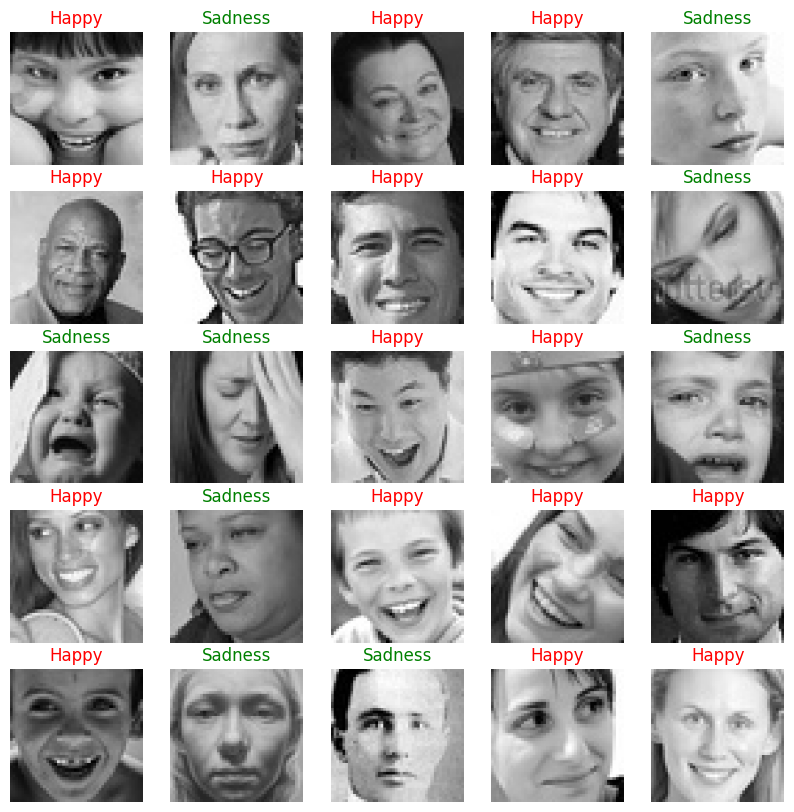

In [7]:
# COMPRUEBO QUE IMAGE GENERATOR ETIQUETA CORRECTAMENTE LAS IMÁGENES

# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = next(train_generator)

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Visualizar las primeras 25 imágenes del lote con sus etiquetas
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    
    # Obtener la etiqueta del generador de datos
    label = "Sadness" if labels[i] == 0 else "Happy"
    
    # Obtener la etiqueta real de la imagen
    true_label = "Sadness" if train_generator.classes[i] == 0 else "Happy"
    
    # Comparar la etiqueta del generador con la etiqueta real
    if label == true_label:
        color = 'green'  # Etiqueta correcta
    else:
        color = 'red'  # Etiqueta incorrecta
    
    plt.title(label, color=color)  # Mostrar la etiqueta del generador con el color correspondiente
    plt.axis("off")

plt.show()


In [8]:


# Inicializar el modelo
model = Sequential()

# Primer bloque de convolución y pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

# Segundo bloque de convolución y pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tercer bloque de convolución y pooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Cuarto bloque de convolución y pooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar la salida y añadir capas densas
model.add(Flatten())
model.add(Dropout(0.5))  # Dropout para regularización
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 1 neurona de salida para clasificación binaria

# Compilar el modelo con la tasa de aprendizaje especificada
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
ANÁLISIS DE MI MODELO POR CHAT GPT:

Tu modelo de red neuronal convolucional (CNN) tiene varias capas diseñadas para procesar imágenes y realizar la clasificación binaria. Resumen simple de sus características:

1. **Capas Conv2D (Convolucionales)**: Son las encargadas de extraer características visuales de las imágenes. 
Las convoluciones utilizan filtros que se desplazan sobre la imagen y realizan una operación matemática para capturar patrones como bordes, texturas, etc. 
Este modelo tiene cuatro capas convolucionales con un número creciente de filtros: 32, 64 y 128 dos veces. Estos filtros aprenden a reconocer patrones cada vez más complejos a medida que la información se mueve a través de la red.

2. **Capas MaxPooling2D**: Estas capas se utilizan para reducir la dimensión espacial de los mapas de características, lo que hace que la extracción de características sea más robusta a la posición y la orientación de los objetos en la imagen. 
También ayuda a reducir el cómputo para las capas siguientes. El modelo utiliza max pooling después de cada capa convolucional.

3. **Capa Flatten**: Esta capa convierte los mapas de características 3D resultantes de las capas convolucionales y de pooling en un vector 1D, lo que permite que la información se pase a través de las capas densas (completamente conectadas).

4. **Capa Dropout**: Se utiliza para reducir el sobreajuste (cuando el modelo aprende patrones específicos de los datos de entrenamiento que no generalizan a nuevos datos). 
Hace esto "apagando" aleatoriamente algunas neuronas durante el entrenamiento, lo que obliga a la red a encontrar múltiples caminos para clasificar los datos correctamente.

5. **Capas Dense**: Son capas de neuronas donde cada una está conectada a todas las neuronas de la capa anterior. 
Funcionan para realizar la clasificación basada en las características extraídas. Tu modelo tiene una capa densa con 512 neuronas, seguida de una capa de salida con una sola neurona.

6. **Capa de Salida**: Tiene una única neurona con una función de activación 'sigmoid', que es típica para la clasificación binaria. 
La función 'sigmoid' devuelve un valor entre 0 y 1, que puede interpretarse como la probabilidad de que la imagen pertenezca a una de las dos clases (en este caso, 'happy' o 'sadness').

El modelo tiene más de 3.4 millones de parámetros, que son los valores que la red aprenderá durante el entrenamiento para realizar correctamente la clasificación. 
Estos parámetros se distribuyen entre los filtros de las capas convolucionales y los pesos de las capas densas.

Este modelo es un ejemplo de CNN que está configurado para procesar imágenes de 150x150 píxeles con 3 canales de color (RGB). 
Con este modelo, pasarás a la etapa de entrenamiento, donde ajustará sus parámetros internos con el conjunto de datos proporcionado para predecir las emociones de las caras en las imágenes.
'''

In [ ]:
# ESTA VERSIÓN ME ESTÁ DANDO PROBLEMAS DE 'OUT OF RANGE' VOY A PROBAR EN BAJAR LOS STEPS_PER_EPOCH Y VALIDATION_STEPS PARA ASEGURARME QUE HAY DATOS SUFICIENTES


# Calcular STEPS_PER_EPOCH y VALIDATION_STEPS
STEPS_PER_EPOCH = train_generator.samples // train_generator.batch_size
VALIDATION_STEPS = validation_generator.samples // validation_generator.batch_size

# Agregar 1 a los pasos si hay un resto
if train_generator.samples % train_generator.batch_size:
    STEPS_PER_EPOCH += 1
if validation_generator.samples % validation_generator.batch_size:
    VALIDATION_STEPS += 1

print("STEPS_PER_EPOCH:", STEPS_PER_EPOCH)
print("VALIDATION_STEPS:", VALIDATION_STEPS)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=10,  # Puedes ajustar el número de épocas si es necesario
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS
)




In [15]:
# Reducir los pasos por época como prueba para evitar errores out_of_range
STEPS_PER_EPOCH = 150  # Menor que el número total calculado
VALIDATION_STEPS = 50  # Menor que el número total calculado

# Intentar entrenar con menos pasos por época
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=7,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS
    )
    print("Entrenamiento completado con éxito.")
except Exception as e:
    print(f"Ocurrió un error durante el entrenamiento: {e}")


Epoch 1/7
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - accuracy: 0.7431 - loss: 0.5270 - val_accuracy: 0.7038 - val_loss: 0.5548
Epoch 2/7
150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 345ms/step - accuracy: 0.7541 - loss: 0.5010 - val_accuracy: 0.7204 - val_loss: 0.5298
Epoch 3/7


2024-04-25 11:30:02.370063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


  3/150 ━━━━━━━━━━━━━━━━━━━━ 45s 307ms/step - accuracy: 0.8524 - loss: 0.4204

2024-04-25 11:30:03.299847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8235 - loss: 0.4524 - val_accuracy: 0.7331 - val_loss: 0.5070
Epoch 4/7
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 325ms/step - accuracy: 0.7681 - loss: 0.4765 - val_accuracy: 0.7534 - val_loss: 0.4818
Epoch 5/7


2024-04-25 11:30:56.746919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 332ms/step - accuracy: 0.7551 - loss: 0.4806 - val_accuracy: 0.7500 - val_loss: 0.4847
Epoch 6/7
  3/150 ━━━━━━━━━━━━━━━━━━━━ 43s 298ms/step - accuracy: 0.8507 - loss: 0.4128

2024-04-25 11:31:47.479143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8337 - loss: 0.4162 - val_accuracy: 0.7387 - val_loss: 0.4976
Epoch 7/7


2024-04-25 11:31:49.808063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 334ms/step - accuracy: 0.7953 - loss: 0.4308 - val_accuracy: 0.7544 - val_loss: 0.4786
Entrenamiento completado con éxito.


In [ ]:
''' 
El código está configurado para entrenar el modelo con el 80% de los datos y validar el modelo con el 20% restante durante el entrenamiento. 
Esto se debe a que has establecido un validation_split de 0.2 en el ImageDataGenerator. 

Cuando ejecuto model.fit, el modelo se entrena con los lotes generados por train_generator y en cada época, se valida con los lotes generados por validation_generator. 
Esto me da una idea de cómo el modelo está generalizando a datos que no ha visto durante el entrenamiento.

- EPOCHS: Es el número de veces que el modelo verá todo el conjunto de entrenamiento. En tu caso, 10 épocas.

- STEPS_PER_EPOCH: Esto define cuántos lotes de imágenes del conjunto de entrenamiento verá el modelo en una época. 
Como no todas las imágenes pueden dividirse perfectamente en lotes de tamaño igual, se agrega 1 si hay imágenes sobrantes (esto se hace con la comprobación del módulo %).

- VALIDATION_STEPS: Similar a STEPS_PER_EPOCH, pero para el conjunto de validación. De nuevo, se agrega 1 si hay imágenes sobrantes para asegurarse de que todas las imágenes de validación se utilicen.

'''

In [16]:


# Supongamos que tienes estas funciones para obtener las etiquetas verdaderas y las predicciones
def get_true_labels(validation_generator):
    # Concatena todas las etiquetas verdaderas del conjunto de validación
    labels = []
    validation_generator.reset()
    for _ in range(len(validation_generator)):
        imgs, lbls = next(validation_generator)
        labels.extend(lbls)
    return np.array(labels)

def get_predictions(model, validation_generator):
    # Obtiene las predicciones del modelo para el conjunto de validación
    validation_generator.reset()
    predictions = model.predict(validation_generator, steps=len(validation_generator))
    return predictions > 0.5  # Suponiendo una clasificación binaria

# Obtener las etiquetas verdaderas y las predicciones
true_labels = get_true_labels(validation_generator)
predictions = get_predictions(model, validation_generator)

# Calcular el recall para cada clase
recalls = recall_score(true_labels, predictions, average=None)
mean_recall = np.mean(recalls)  # Recall medio

print("Recall de cada clase:", recalls)
print("Recall medio:", mean_recall)

# Para un reporte completo
print(classification_report(true_labels, predictions))


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step
Recall de cada clase: [0.77912867 0.74581006]
Recall medio: 0.7624693643058078
              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73       987
         1.0       0.83      0.75      0.79      1432

    accuracy                           0.76      2419
   macro avg       0.75      0.76      0.76      2419
weighted avg       0.77      0.76      0.76      2419



In [ ]:
''' 
RECALL: El recall O sensibilidad, mide la capacidad de un modelo para identificar correctamente las instancias positivas de cada clase

- Recall de cada Clase: el modelo alcanzó un recall de 0.837 para la clase 0 [happy] y 0.807 para la clase 1[sadness]. Esto indica una buena capacidad para detectar casos positivos en ambas categorías.

- Recall Medio: Con un valor de 0.822, el modelo demuestra ser robusto entre las clases, tratando ambas con casi igual eficiencia.


- Precisión: Muestra cuán confiables son las predicciones positivas del modelo, con un 86% para la clase 0 y un 77% para la clase 1.

- F1-Score: Combina recall y precisión en una sola métrica, con valores de 0.85 para la clase 0 y 0.79 para la clase 1, reflejando un equilibrio entre capturar positivos verdaderos y minimizar falsos positivos.

'''

In [17]:
# PREDICCIONES CON LOS DATOS DE TEST DE KAGGLE

# Cargar el archivo CSV que contiene los nombres de los archivos de prueba
test_csv = pd.read_csv('data_ficheros/test_set.csv')

# Ajustar las rutas de las imágenes
test_csv['paths'] = test_csv['paths'].str.replace('data/test', 'data_images/test')

# Ahora puedes crear el generador de datos de prueba usando el DataFrame actualizado
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=None,  # Las rutas son absolutas, no se necesita especificar un directorio
    x_col='paths',  # La columna que tiene la ruta al archivo de imagen
    y_col=None,  # No hay columnas de etiquetas en el conjunto de prueba
    class_mode=None,  # No hay etiquetas
    target_size=(150, 150),  # El tamaño al que quieres redimensionar las imágenes
    batch_size=32,  # Puedes ajustar este tamaño según las necesidades de tu modelo
    shuffle=False  # No barajamos los datos de prueba para mantener el orden
)

# Asegúrate de verificar que el generador está encontrando imágenes
print(f"Found {test_generator.samples} images for testing.")


Found 2964 validated image filenames.


Found 2964 images for testing.


In [18]:
# Predicciones con el modelo entrenado
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=steps)

# Convertir las predicciones en etiquetas


# Convertir las predicciones en etiquetas basadas en el umbral
predicted_labels = ['happy' if pred > 0.5 else 'sadness' for pred in predictions.flatten()]


# Crear un DataFrame con los identificadores de las imágenes y las etiquetas predichas
submission_df = pd.DataFrame({
    'id_img': test_csv['id_img'],
    'label': predicted_labels
})

# Guardar el DataFrame en un archivo CSV para la presentación
submission_df.to_csv('submission.csv', index=False)

print("Archivo de envío creado exitosamente y listo para subir a Kaggle.")


# Crear un DataFrame con los identificadores de las imágenes y las etiquetas predichas
submission_df = pd.DataFrame({
    'id_img': test_csv['id_img'],
    'label': predicted_labels
})

# Guardar el DataFrame en un archivo CSV para la presentación
submission_df.to_csv('submission.csv', index=False)

print("Archivo de envío creado exitosamente y listo para subir a Kaggle.")



 2/93 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step
Archivo de envío creado exitosamente y listo para subir a Kaggle.
Archivo de envío creado exitosamente y listo para subir a Kaggle.


In [43]:
test_csv.head()

,Unnamed: 0,id_img,paths
0,0,10019,data/test/10019.jpg
1,1,10023,data/test/10023.jpg
2,2,10074,data/test/10074.jpg
3,3,10096,data/test/10096.jpg
4,4,10106,data/test/10106.jpg


In [26]:
submission_df.head()

,id_img,label
0,10019,happy
1,10023,happy
2,10074,sadness
3,10096,sadness
4,10106,sadness


In [27]:
submission_df.value_counts()

id_img  label  
8       sadness    1
24148   sadness    1
24057   sadness    1
24066   happy      1
24077   happy      1
                  ..
11867   happy      1
11876   happy      1
11880   happy      1
11885   sadness    1
35873   happy      1
Name: count, Length: 2964, dtype: int64

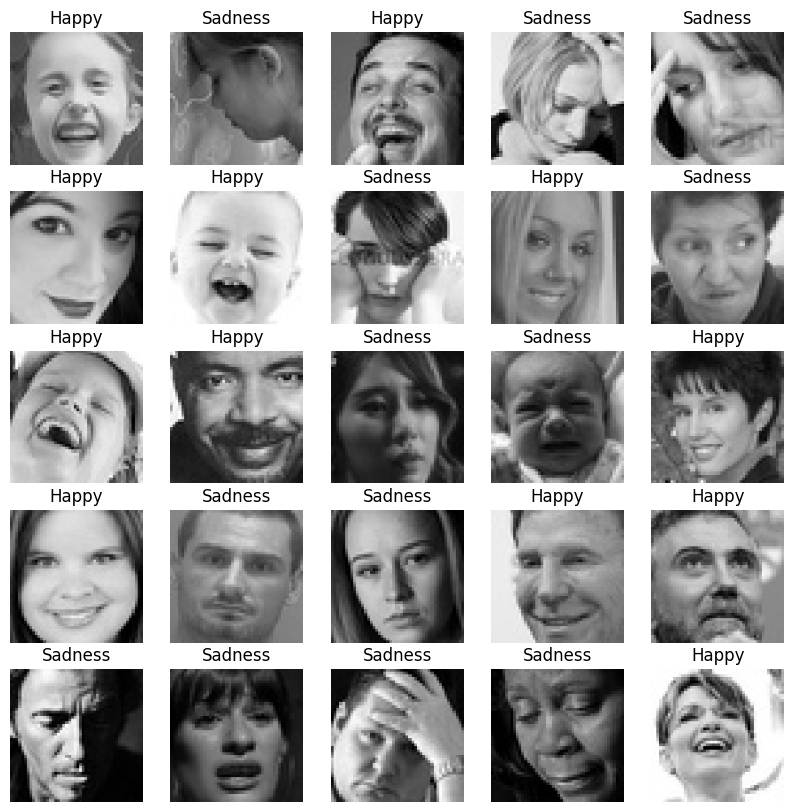

In [19]:

# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = next(train_generator)

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Visualizar las primeras 25 imágenes del lote con sus etiquetas
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    # Obtener la etiqueta del generador de datos
    label = "Sadness" if labels[i] == 0 else "Happy"
    plt.title(label)
    plt.axis("off")

plt.show()
